# Validação dos resultados

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import tsfel
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

plt.style.use('../tcc.mplstyle')

In [2]:
SAVE_PATH = Path('D:/dados_tcc/files')
FIG_PATH = Path('G:/Meu Drive/TCC/TCC Texto/Figuras')

# https://stackoverflow.com/a/65467569
class ScalerSelector(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, X, y=None):
        return self.scaler.fit(X)

    def transform(self, X, y=None):
        return self.scaler.transform(X)

## Sistema estudado

Definição matemática do sistema estudado. Pode-se alterar aqui o sinal de entrada $u(t)$

In [67]:
def system(t, x, phi0, phif, t0):
    """Representation of the LPV system

    Args:
        t (float):  simulation time in seconds
        x (list): _description_
        phi0 (float): lower limit of the LPV parameter
        phif (float): upper limit of the LPV parameter
        t0 (float): moment when the LPV parameter changes, in seconds
    """

    # LPV parameter
    phi = phi0 if t <= t0 else phif

    # Input signal
    u = np.cos(t)

    # System definition in state-space
    A = np.array([[0, phi], [-phi, 0]])
    B = np.array([[0], [1]])

    dx = np.dot(A, x) + np.dot(B, u)

    return dx


def system_pred(t, x, phi_pred, window_step, window_size, fs=10_000):

    # LPV parameter
    t0 = t * fs

    if t0 < window_size:
        phi = 0
    else:
        idx = int((t0 - window_size) // window_step)

        if idx > len(phi_pred) - 1:
            phi = phi_pred[-1]
        else:
            phi = phi_pred[idx]
    

    # Input signal
    u = np.cos(t)

    # System definition in state-space
    A = np.array([[0, phi], [-phi, 0]])
    B = np.array([[0], [1]])

    dx = np.dot(A, x) + np.dot(B, u)

    return dx

In [64]:
def knn(features):
    with open(SAVE_PATH / 'knn.joblib', 'rb') as file:
        model = joblib.load(file)

    return model.predict(features)


def xgb(features):
    with open(SAVE_PATH / 'xgb.joblib', 'rb') as file:
        model = joblib.load(file)

    return model.predict(features)


def plot_system(t, t0, x1, xgb, knn, save, label, save_path):
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, 'k', label='$y(t)$')
    plt.plot(t, xgb, '--', label='XGBoost')
    plt.plot(t, knn, '-.', label='KNN')
    plt.axvline(x=t0, color='red', alpha=1, ls='--', label='$t_0$')

    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')

    plt.legend(bbox_to_anchor=(1.03, 0.5), loc='center left')
    plt.tight_layout()

    if save:
        plt.savefig(save_path / f'{label}_simulation.pdf')

    plt.show()


def simulation(
    fs=10_000,
    window_size=10_000,
    overlap=0.75,
    tf=20,
    y0=[0, 0],
    params=(5, 10, 12.5),
    save=False,
    label=None,
    save_path=None,
):

    WINDOW_STEP = int(round(window_size * (1 - overlap)))
    t = np.linspace(0, tf, fs * tf)
    cfg = tsfel.get_features_by_domain(json_path='../selected_features.json')
    _, _, t0 = params

    x1 = solve_ivp(
        system,
        t_span=[0, tf],
        y0=y0,
        dense_output=True,
        vectorized=True,
        args=params,
    ).sol(t)[0]

    X_dataframe = pd.DataFrame({'x1': x1})
    with warnings.catch_warnings(action='ignore'):
        features = tsfel.time_series_features_extractor(
            cfg,
            X_dataframe,
            fs=10_000,
            window_size=window_size,
            overlap=overlap,
            verbose=0,
        )

    # predictions
    xgb_pred = xgb(features)
    knn_pred = knn(features)

    x1_xgb = solve_ivp(
        system_pred,
        t_span=[0, 20],
        y0=[0, 0],
        dense_output=True,
        vectorized=True,
        args=(xgb_pred, WINDOW_STEP, window_size),
    ).sol(t)[0]

    x1_knn = solve_ivp(
        system_pred,
        t_span=[0, 20],
        y0=[0, 0],
        dense_output=True,
        vectorized=True,
        args=(knn_pred, WINDOW_STEP, window_size),
    ).sol(t)[0]

    plot_system(t, t0, x1, x1_xgb, x1_knn, save, label, save_path)


## Simulações

Testando os modelos em alguns casos hipotéticos

### Caso 1

$
\begin{cases}
    u(t) = \mathrm{step}(t) \\
    \theta_0 = 5  \\
    \theta_f = 1.5  \\
    t_0 = 12.5  
\end{cases}
$

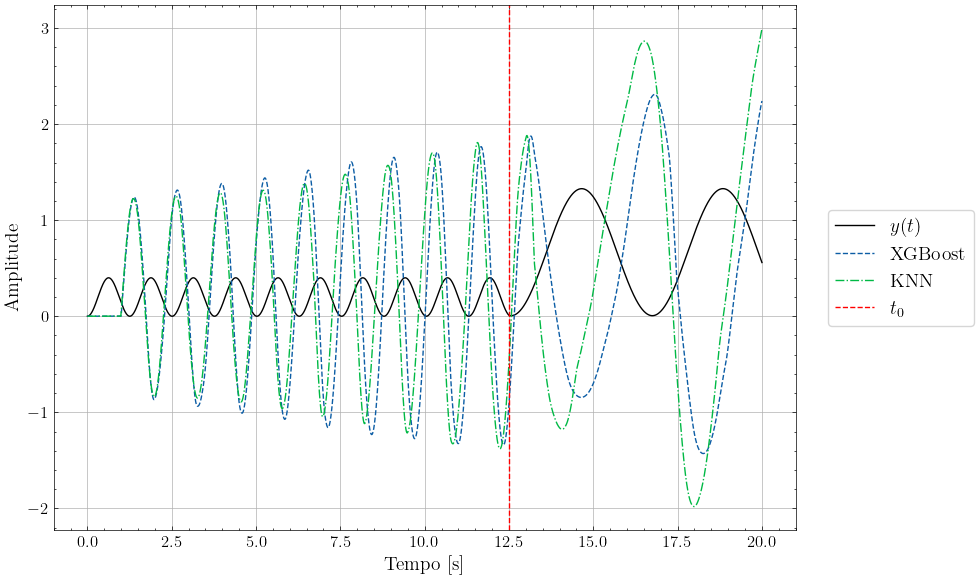

In [26]:
simulation(
    params=(5, 1.5, 12.5),
    save=True,
    label='5_1.5_125',
    save_path=FIG_PATH,
)

### Caso 2

$
\begin{cases}
    u(t) = \cos(2\pi t) \\
    \theta_0 = 1  \\
    \theta_f = 2.15  \\
    t_0 = 4.2  
\end{cases}
$

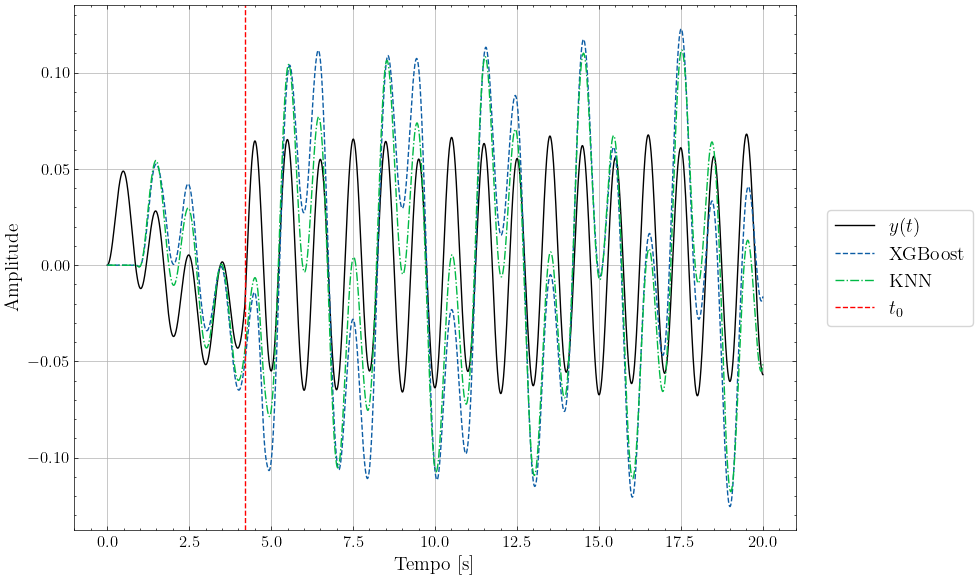

In [29]:
simulation(
    params=(1, 2.15, 4.2),
    save=True,
    label='1_2.15_4.2',
    save_path=FIG_PATH,
)

### Caso 3

$
\begin{cases}
    u(t) = \cos(t) \\
    \theta_0 = 1  \\
    \theta_f = 5.5 \\
    t_0 = 10 
\end{cases}
$

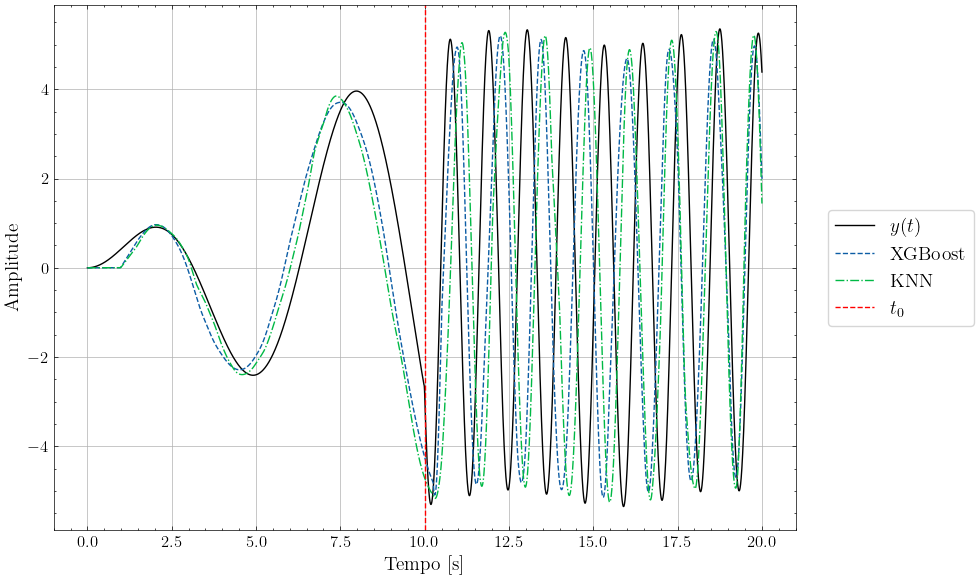

In [32]:
simulation(
    params=(1, 5.5, 10),
    save=True,
    label='1_5.5_10',
    save_path=FIG_PATH
)

### Caso 4

$
\begin{cases}
    u(t) = \cos(2\pi 10t) \\
    \theta_0 = 2  \\
    \theta_f = 4 \\
    t_0 = 13 
\end{cases}
$

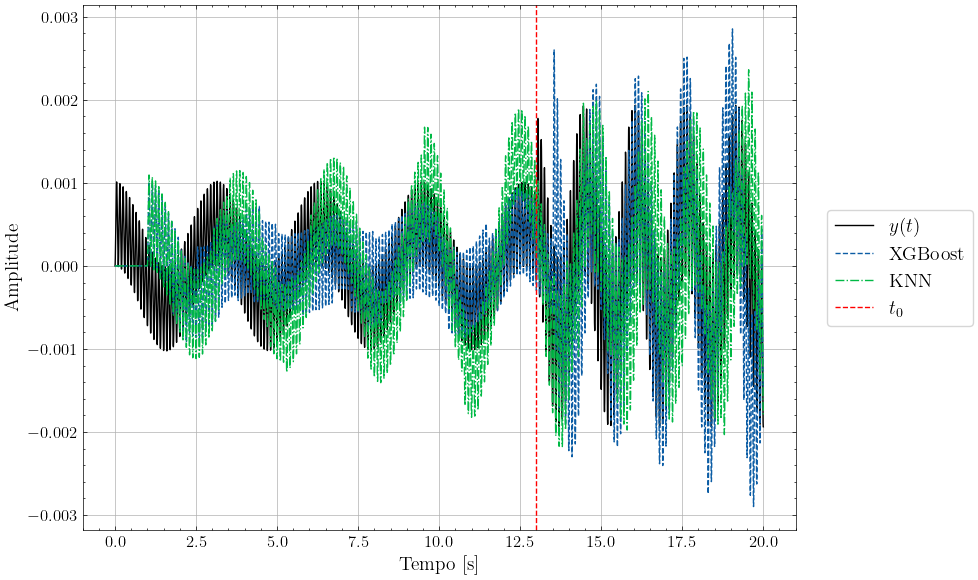

In [37]:
simulation(
    params=(2, 4, 13),
    save=True,
    label='2_4_13',
    save_path=FIG_PATH,
)

### Caso 5

$
\begin{cases}
    u(t) = \cos(2\pi 5t) \\
    \theta_0 = 1  \\
    \theta_f = 1.1 \\
    t_0 = 10 
\end{cases}
$

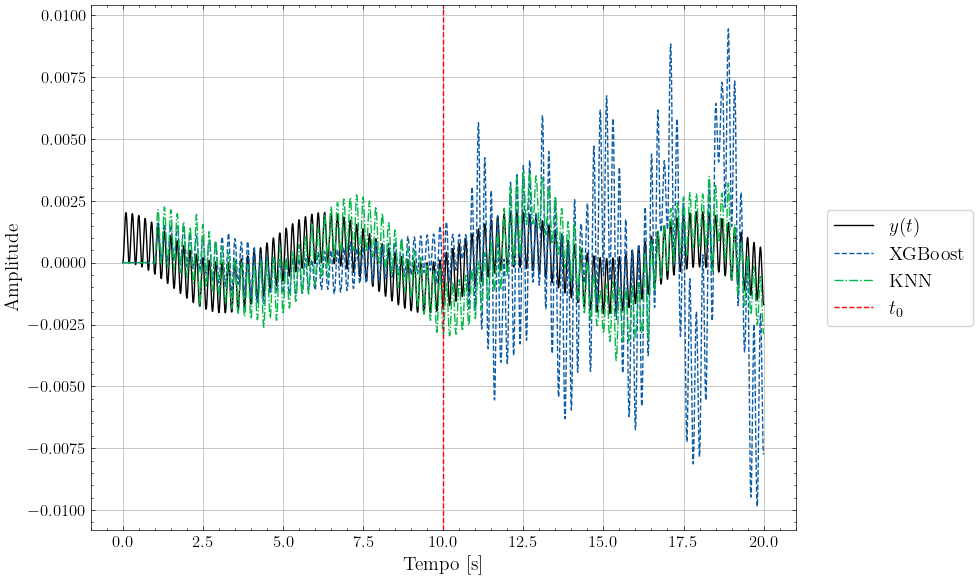

In [41]:
simulation(
    params=(1, 1.1, 10),
    save=True,
    label='1_1.1_10',
    save_path=FIG_PATH
)